In [1]:
import pandas
import numpy as np

In [2]:
data_set = pandas.read_csv("files/train.csv")
data_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data_set.info()
print(list(data_set["Embarked"]).count("S"),
      list(data_set["Embarked"]).count("C"),
      list(data_set["Embarked"]).count("Q"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
644 168 77


# Preprocessing the data

#### The cabin column might give the info of where the passengers where when the titanic crashed, which may be useful. Even though it is missing a lot of values, it is worth a more thorough investigation

In [4]:
class AttributeReducer():
    
    def __init__(self, remove_passenger_id=True, remove_cabin=True):
        self.remove_passenger_id = remove_passenger_id
        self.remove_cabin = remove_cabin
        
    def fit(self, X, y=None):
        return self          
    
    def transform(self, X):
        X.drop(["Name", "Ticket"], axis=1, inplace=True)
        if self.remove_passenger_id:
            X.drop(["PassengerId"], axis=1, inplace=True)
        if self.remove_cabin:
            X.drop(["Cabin"], axis=1, inplace=True)
            
        return X

    
class AttributeFiller():
    
    def fit(self, X, y=None):
        return self          
    
    def transform(self, X):
        X["Age"] = X["Age"].fillna(X["Age"].mean(skipna=True))
        X["Embarked"] = X["Embarked"].fillna("S")
        X["Fare"] = X["Fare"].fillna(X["Fare"].mean(skipna=True))
            
        return X

In [5]:
def preprocess(df):
    reducer, filler = AttributeReducer(), AttributeFiller()
    
    df_ = df.copy()
    
    df_ = reducer.fit(df_).transform(df_)
    df_ = filler.fit(df_).transform(df_)
    
    return df_

In [6]:
preproc_df = preprocess(data_set)  # pre-preprocessing the data

In [7]:
preproc_df.info()
print(list(preproc_df["Embarked"]).count("S"),
      list(preproc_df["Embarked"]).count("C"),
      list(preproc_df["Embarked"]).count("Q"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
646 168 77


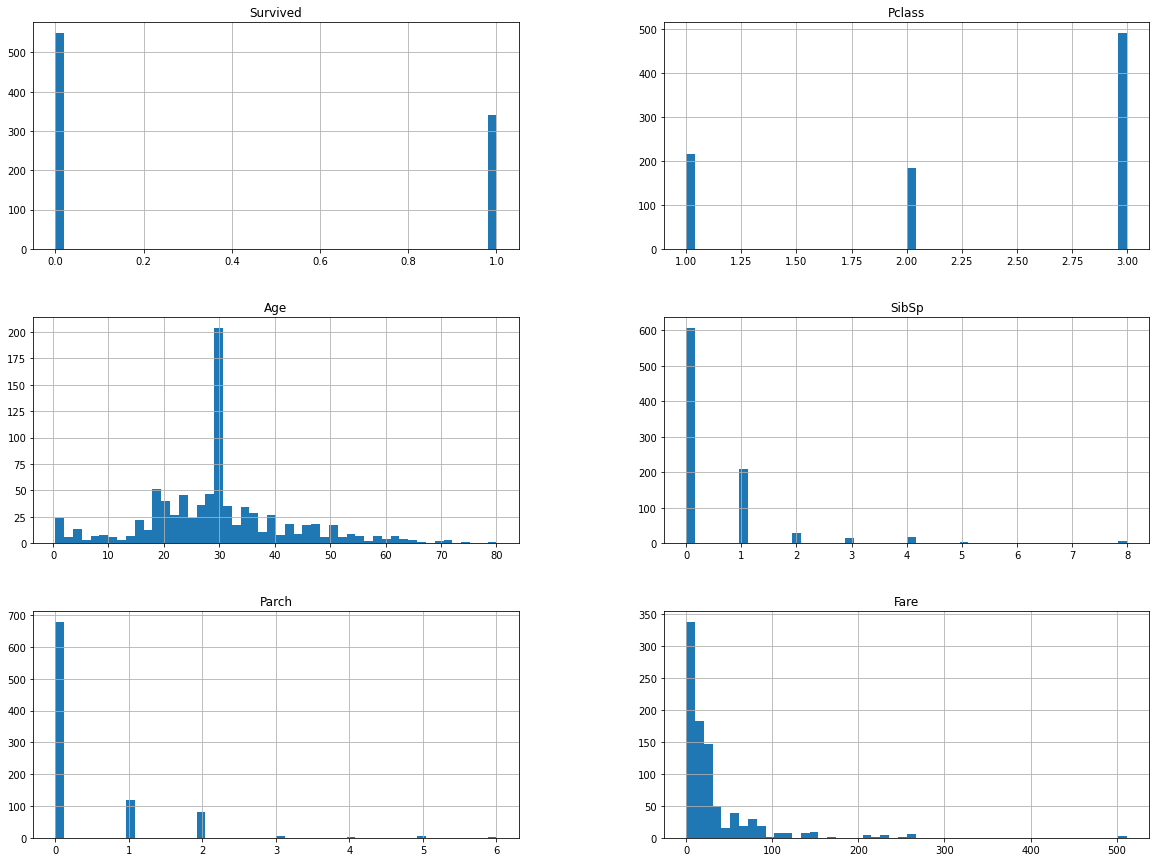

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt 

preproc_df.iloc[:, :].hist(bins = 50, figsize = (20,15))
plt.show()

#### The age seems to be a good feature for measuring the chances of survival of a passanger. Let's use it to separate the train set and the test set and make both of them representative

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

preproc_df["age_cats"] = pandas.cut(preproc_df["Age"], 
                                    bins=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 100], 
                                    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

separator = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in separator.split(preproc_df, preproc_df["age_cats"]):
    train_set = preproc_df.loc[train_index]
    test_set = preproc_df.loc[test_index]
    
for set_ in (train_set, test_set):
    set_.drop("age_cats", axis=1, inplace=True)
    
train_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
99,0,2,male,34.0,1,0,26.0000,S
376,1,3,female,22.0,0,0,7.2500,S
307,1,1,female,17.0,1,0,108.9000,C
890,0,3,male,32.0,0,0,7.7500,Q
631,0,3,male,51.0,0,0,7.0542,S


In [10]:
print(train_set.shape, test_set.shape)

(801, 8) (90, 8)


In [11]:
X_train, y_train = train_set.drop('Survived', axis=1), train_set['Survived']
X_test, y_test = test_set.drop('Survived', axis=1), test_set['Survived']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(801, 7) (801,) (90, 7) (90,)


In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_columns = ['Sex', 'Embarked', 'Pclass']

num_columns = list(X_train.columns)
for att in cat_columns:
    num_columns.remove(att)

pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_columns),
    ('cat', OneHotEncoder(), cat_columns)
])

X_train_tf = pipeline.fit_transform(X_train)
pandas.DataFrame(X_train_tf)                      # Preprocessing: Done!

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.328084,0.442879,-0.476276,-0.125426,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.592162,-0.466727,-0.476276,-0.513600,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.975598,0.442879,-0.476276,1.590816,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.174710,-0.466727,-0.476276,-0.503248,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.631765,-0.466727,-0.476276,-0.517653,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
796,-1.589095,-0.466727,2.033574,-0.238773,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
797,-0.001739,6.810122,2.033574,0.776170,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
798,0.711520,0.442879,-0.476276,0.493580,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
799,-1.895844,1.352486,0.778649,-0.264997,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Training a model

In [21]:
### MODEL: Stochastic Gradient Descent Classifier

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score

sgd = SGDClassifier(random_state=42)

accuracy = cross_val_score(sgd, X_train_tf, y_train, cv=20, scoring="accuracy")

predictions = cross_val_predict(sgd, X_train_tf, y_train, cv=20)
score = f1_score(y_train, predictions)

In [22]:
print("Accuracy:", accuracy.mean())  # Decent
print("Std dev: ", accuracy.std())   # Could be better
print("F1 score:", score)            # Quite bad

Accuracy: 0.7329268292682928
Std dev:  0.10094198656650691
F1 score: 0.6514657980456027


In [23]:
### MODEL: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) 

accuracy = cross_val_score(forest_clf, X_train_tf, y_train, cv=20, scoring="accuracy")

predictions = cross_val_predict(forest_clf, X_train_tf, y_train, cv=20)
score = f1_score(y_train, predictions)

In [24]:
print("Accuracy:", accuracy.mean())  # Better
print("Std dev: ", accuracy.std())   # Good
print("F1 score:", score)            # Better

Accuracy: 0.7978658536585367
Std dev:  0.06973128183014558
F1 score: 0.7281879194630873


In [25]:
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [27]:
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(forest_clf, random_grid, n_iter=100, cv = 3, random_state=42)
rand_search.fit(X_train_tf, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [28]:
rand_search.best_score_

0.8277153558052435

In [29]:
new_rf_clf = rand_search.best_estimator_

new_accuracy = cross_val_score(new_rf_clf, X_train_tf, y_train, cv=20, scoring="accuracy")

new_predictions = cross_val_predict(new_rf_clf, X_train_tf, y_train, cv=20)
new_score = f1_score(y_train, new_predictions)

In [30]:
print("Accuracy:", new_accuracy.mean())  # Better
print("Std dev: ", new_accuracy.std())   # Maintained the consistency, great
print("F1 score:", new_score)            # Better

Accuracy: 0.8339939024390244
Std dev:  0.07028054044300834
F1 score: 0.7662565905096661


# Testing in the test set

In [31]:
X_test_tf = pipeline.transform(X_test)
pandas.DataFrame(X_test_tf)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-2.221764,1.352486,0.778649,-0.264997,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.001739,0.442879,-0.476276,-0.330382,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.898911,-0.466727,-0.476276,0.857945,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.481458,-0.466727,-0.476276,-0.500230,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.898911,-0.466727,-0.476276,-0.508511,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.001739,-0.466727,-0.476276,-0.505749,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
86,1.401704,-0.466727,-0.476276,-0.114040,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
87,-0.001739,-0.466727,-0.476276,-0.500230,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
88,-0.898911,0.442879,0.778649,-0.501091,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [32]:
predictions = new_rf_clf.predict(X_test_tf)
print("Final score:", sum(predictions == y_test) / len(predictions))

Final score: 0.7888888888888889


#### It probably overfitted the train set a little bit, but I'm happy with the results!!

# Generating the output

In [33]:
evaluation_set = pandas.read_csv('files/test.csv')
evaluation_set

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [34]:
preproc_eval_set = preprocess(evaluation_set)
final_eval_set = pipeline.transform(preproc_eval_set)
pandas.DataFrame(final_eval_set)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.366427,-0.466727,-0.476276,-0.501609,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.325017,0.442879,-0.476276,-0.518775,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.475324,-0.466727,-0.476276,-0.463137,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.208726,-0.466727,-0.476276,-0.484357,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.592162,0.442879,0.778649,-0.409310,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.042239,-0.466727,-0.476276,-0.497037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
414,0.711520,-0.466727,-0.476276,1.590816,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
415,0.673176,-0.466727,-0.476276,-0.513600,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
416,0.042239,-0.466727,-0.476276,-0.497037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [35]:
pandas.DataFrame(final_eval_set).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       418 non-null    float64
 1   1       418 non-null    float64
 2   2       418 non-null    float64
 3   3       418 non-null    float64
 4   4       418 non-null    float64
 5   5       418 non-null    float64
 6   6       418 non-null    float64
 7   7       418 non-null    float64
 8   8       418 non-null    float64
 9   9       418 non-null    float64
 10  10      418 non-null    float64
 11  11      418 non-null    float64
dtypes: float64(12)
memory usage: 39.3 KB


In [36]:
predictions = new_rf_clf.predict(final_eval_set)

output_df = pandas.DataFrame({
    "PassengerId": evaluation_set['PassengerId'],
    "Survived": predictions
})

output_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [37]:
output_df.to_csv("files/output.csv", index=False)